The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. It is a multivariate series comprised of seven variables (besides the date and time)

􏰀 . global active power: The total active power consumed by the household (kilowatts).      
􏰀 . global reactive power: The total reactive power consumed by the household (kilowatts).       
 . voltage: Average voltage (volts).      
􏰀 . global intensity: Average current intensity (amps).   
􏰀 . sub metering 1: Active energy for kitchen (watt-hours of active energy).   
􏰀 . sub metering 2: Active energy for laundry (watt-hours of active energy).   
􏰀 . sub metering 3: Active energy for climate control systems (watt-hours of active energy).  

In [20]:
import numpy  as np
import pandas as pd

from math import sqrt

from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

In [ ]:
# load the new file
dataset = pd.read_csv('./Downloads/data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

First, we can mark all missing values indicated with a ‘?’ character with a NaN value, which is a float. This will allow us to work with the data as one array of floating point values rather than mixed types (less efficient.). We will process the original data and save into csv for project.

In [ ]:
# mark all missing values
dataset.replace('?', np.nan, inplace=True) # make dataset numeric
dataset = dataset.astype('float32')

We also need to fill in the missing values now that they have been marked. A very simple approach would be to copy the observation from the same time the day before. We can implement this in a function named fill missing() that will take the NumPy array of the data and copy values from exactly 24 hours ago.

In [ ]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]): 
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
# fill missing
fill_missing(dataset.values)

In [ ]:
dataset.isna().sum()

In [ ]:
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] +
    values[:,6])
# save updated dataset
dataset.to_csv('./Downloads/data/household_power_consumption.csv')

**Given recent power consumption**, what is the expected power consumption for the week ahead? This requires that a predictive model forecast the total active power for each day over the next seven days.   

Technically, this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps. A model that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.

It would be useful to **downsample the per-minute observations** of power consumption to **daily totals**. This is not required, but makes sense, given that we are interested in total power per day. We can achieve this easily using the resample() function on the Pandas DataFrame. Calling this function with the argument ‘D’ allows the loaded data indexed by date-time to be grouped by day (see all offset aliases). We can then calculate the sum of all observations for each day and create a new dataset of daily power consumption data for each of the eight variables. 

In [ ]:
# resample minute data to total for each day for the power usage dataset

# load the new file
dataset = pd.read_csv('./Downloads/data/household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime']) 

dataset.head()

In [ ]:
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save 

daily_data.to_csv('./Downloads/data/household_power_consumption_days.csv')
daily_data.head()

### Select evaluation metric.  

A forecast will be comprised of seven values, one for each day of the week ahead. It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons:   
􏰀 * To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).   
􏰀 * To contrast models based on their skills at different lead times (e.g. models good at +1 day vs models good at days +5).  

The units of the total power are kilowatts and it would be useful to have an error metric that was also in the same units. Both Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) fit this bill, although RMSE is more commonly used and will be adopted in this tutorial. Unlike MAE, RMSE is more punishing of forecast errors. The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7.   

The function evaluate forecasts() below will implement this behavior and return the performance of a model based on multiple seven-day forecasts.

In [2]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted): 
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
    # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i]) # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
          # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


We will use the first three years of data for training predictive models and the final year for evaluating models. The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday.   

We will split the data into standard weeks, working backwards from the test dataset. The final year of the data is in 2010 and the first Sunday for 2010 was January 3rd. The data ends in mid November 2010 and the closest final Saturday in the data is November 20th. This gives 46 weeks of test data

In [5]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6] 
    # restructure into windows of weekly data 
    train = np.array(np.split(train, len(train)/7)) 
    test = np.array(np.split(test, len(test)/7)) 
    
    return train, test

# load the new file
dataset = pd.read_csv('./Downloads/data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)

In [6]:
# validate train data
print('train shape ',train.shape)
print('validate train ',train[0, 0, 0], train[-1, -1, 0])

# validate test
print('test shape ',test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

train shape  (159, 7, 8)
validate train  3390.46 1309.2679999999998
test shape  (46, 7, 8)
2083.4539999999984 2197.006000000004


Running the example shows that indeed the train dataset has 159 weeks of data, whereas the test dataset has 46 weeks.   

### Walk-forward validation   


Models will be evaluated using a scheme called walk-forward validation. This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week



In [18]:
# evaluate a single model
def evaluate_model(model_func, train, test): 
    # history is a list of weekly data
    history = [x for x in train]
    
    # walk-forward validation over each week 
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = np.array(predictions)
      # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))


### Base models.  

There are serveral ways to define base model to compare to final model, among them:   
    
    
1. Daily Persistence Forecast.   
2. Weekly Persistent Forecast.   
3. Weekly One-Year-Ago Persistent Forecast  

### Daily Persistence Forecast
This model takes the active power from the last day prior to the forecast period (e.g. Saturday) and uses it as the value of the power for each day in the forecast period (Sunday to Saturday).


In [14]:

# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day 
    value = last_week[-1, 0] 
    #prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

### Weekly Persistent Forecast   

We can use the entire prior week as the forecast for the week ahead assuming that that next week will be very similar to this week.

In [9]:
# weekly persistence model
def weekly_persistence(history):
# get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

### Weekly One-Year-Ago Persistent Forecast   

The idea of using the same week last year to predict next week. So we use the week of observations from 52 weeks ago as the forecast, based on the idea that next week will be similar to the same week one year ago. 

In [10]:
# week one year ago persistence model
def week_one_year_ago_persistence(history): 
    # get the data for the prior week 
    last_week = history[-52]
    return last_week[:, 0]

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


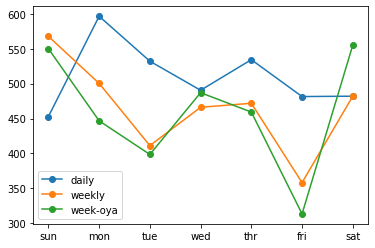

In [21]:
# define the names and functions for the models we wish to evaluate

models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
  # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
      # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    plt.plot(days, scores, marker='o', label=name)
# show plot
plt.legend()
plt.show()


We can see that the weekly strategy performs better than the daily strategy and that the week one year ago (week-oya) performs slightly better again. We can see this in both the overall RMSE scores for each model and in the daily scores for each forecast day. 

**One exception** is the forecast error for the first day (Sunday) where it appears that the daily persistence model performs better than the two weekly strategies. We can use the week-oya strategy with an overall RMSE of 465.294 kilowatts as the baseline in performance for more sophisticated models to be considered skillful on this specific framing of the problem.   

We can see the same observed pattern of the weekly strategies performing better than the daily strategy in general, except in the case of the first day. It is surprising that the week one-year-ago performs better than using the prior week. 